Get data

In [1]:
!pip3 install tqdm

In [2]:
import os
from IPython.display import clear_output
import cv2
from sklearn.manifold import TSNE
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
import plotly.express as px

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Run only in collab:

In [3]:
# download dataset
if 'google.colab' in str(get_ipython()):
    from google.colab import drive
    drive.mount('/content/gdrive')
    os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/My Drive/Kaggle"

    !pip install kaggle
    !mkdir data
    !kaggle datasets download -d gpiosenka/100-bird-species
    !unzip 100-bird-species.zip -d data

    clear_output()

Getting all data

In [4]:
DATA_PATH = f'{os.getcwd()}/data'
TRAIN_PATH = f'{DATA_PATH}/train'
TEST_PATH = f'{DATA_PATH}/test'
TYPE_PATH = "{}/{}"

NUM_ELEMENTS_TO_SHOW = 200

from tqdm import tqdm

# Get train and test data with labels
def get_data_and_labels(n_first_classes = None):
    types = os.listdir(TRAIN_PATH)

    train, test = [], []
    
    n_class = 0
    for tp in tqdm(types):
        if (n_class == n_first_classes):
            break
        
        train_type_path = TYPE_PATH.format(TRAIN_PATH,tp)
        for img in os.listdir(train_type_path):
            image = cv2.imread(TYPE_PATH.format(train_type_path,img), cv2.IMREAD_COLOR)
            train.append([tp,image])

        test_type_path = TYPE_PATH.format(TEST_PATH,tp)
        for img in os.listdir(test_type_path):
            image = cv2.imread(TYPE_PATH.format(test_type_path,img), cv2.IMREAD_COLOR)
            test.append([tp,image])
        n_class += 1
        
    train_labels = [i[0] for i in train]
    train_data = [i[1] for i in train]

    test_labels = [i[0] for i in test]
    test_data = [i[1] for i in test]
    print("Loading data done")
    
    return train_labels, train_data, test_labels, test_data

train_labels, train_data, test_labels, test_data = get_data_and_labels(n_first_classes = 10)

  4%|▍         | 10/225 [00:01<00:38,  5.52it/s]

Loading data done


Labels encoding

In [5]:
types = list(set(train_labels))
encoder = {key: ind for ind, key in enumerate(types)}
decoder = {val: key for key, val in encoder.items()}
encoder

{'AMERICAN COOT': 3,
 'BANANAQUIT': 9,
 'CANARY': 8,
 'CHARA DE COLLAR': 5,
 'CRESTED AUKLET': 6,
 'DARK EYED JUNCO': 4,
 'EASTERN ROSELLA': 1,
 'EMPEROR PENGUIN': 0,
 'HOUSE FINCH': 2,
 'TURQUOISE MOTMOT': 7}

Getting train and test data and labels

In [6]:
train_labels, test_labels = np.array(train_labels), np.array(test_labels)
train_data, test_data = np.array(train_data), np.array(test_data)

Showing data length

In [7]:
print(len(test_data), len(test_labels), len(train_data), len(train_labels))

50 50 1489 1489


Show train data

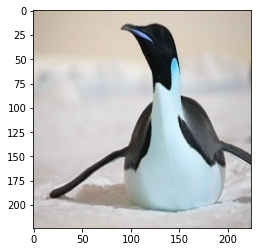

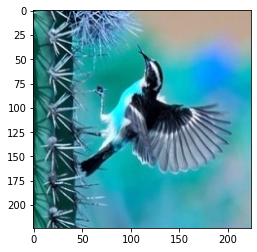

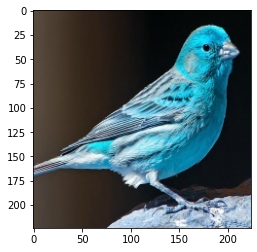

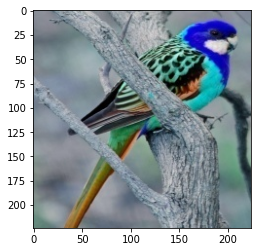

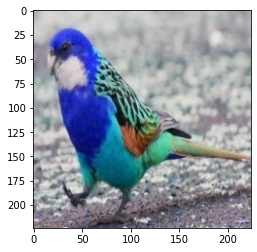

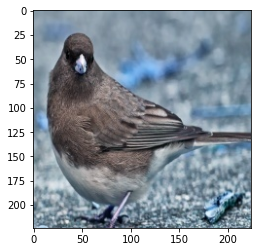

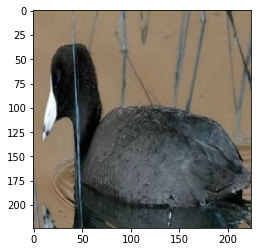

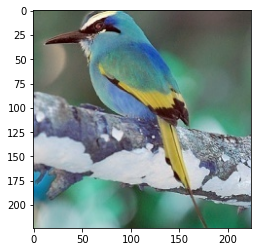

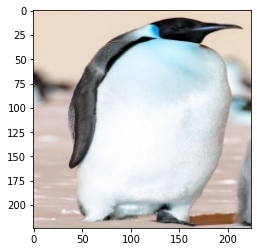

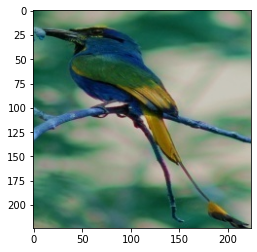

<Figure size 432x288 with 0 Axes>

In [8]:
from random import choice
for i in range(10):
    plt.imshow(choice(train_data))
    plt.figure()

In [9]:
def show_examples(imgs):
    plt.figure(figsize=(10, 10))
    for i in range(25):
        plt.subplot(5, 5, i + 1)
        plt.imshow(imgs[i])
    plt.show()

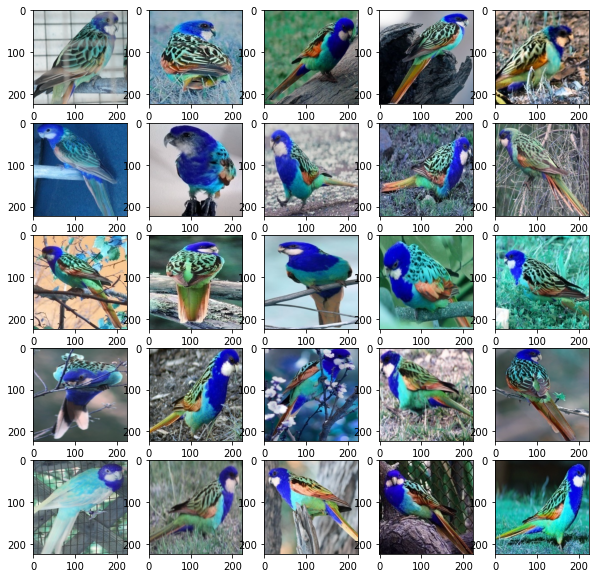

In [10]:
show_examples(train_data)

Get tSNE embeddings

In [11]:
TSNE_TRAIN_SHAPE = (40, 40)
ENCODER_TRAIN_SHAPE = (120, 120)

In [12]:
from sklearn.model_selection import train_test_split

def train_embeddings(data):
    return TSNE(n_components=3).fit_transform(data)

def get_tsne_train_data(imgs, labels):
    resized = np.array([cv2.resize(cv2.cvtColor(im, cv2.COLOR_BGR2GRAY), TSNE_TRAIN_SHAPE) for im in imgs])
    X_Data, _, X_labels, _ = train_test_split(resized, labels, test_size=0.8, stratify=labels)
    return X_Data.flatten().reshape(X_Data.shape[0], TSNE_TRAIN_SHAPE[0] * TSNE_TRAIN_SHAPE[1] * 1), X_labels


In [13]:
tsne_train_data, tsne_train_labels = get_tsne_train_data(train_data, train_labels)
print(len(tsne_train_data), len(tsne_train_labels))
tsne_embeddings = train_embeddings(tsne_train_data)

297 297


Show 2d image distribution

In [14]:
def plot2d(tsne, labels):
    num = len(labels)
    palette = sb.color_palette("bright", np.unique(labels[:num]).shape[0])
    plot = sb.scatterplot(tsne[:, 0], tsne[:, 1], hue=labels[:num], legend='full', palette=palette).set_title(
        "Distribution")
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    
def plot3d(tsne, train_labels):
    num = len(train_labels)
    fig = px.scatter_3d(x=tsne[::, 0],
                        y=tsne[::, 1],
                        z=tsne[::, 2],
                        color=[str(label) for label in train_labels[:num]],
                        opacity=0.7)
    fig.show()


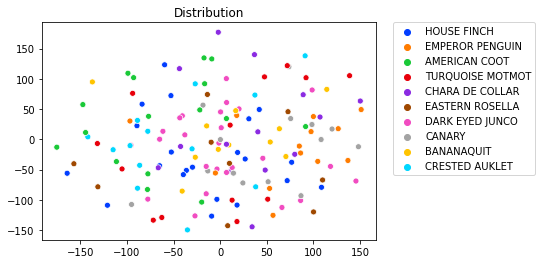

In [15]:
plot2d(tsne_embeddings[::2], tsne_train_labels[::2]) 

Show 3d image distribution

In [16]:
plot3d(tsne_embeddings[::2], tsne_train_labels[::2])

Autoencoder class

In [17]:
import time
import torch
from torch import nn
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torch.nn import Parameter
import torch.nn.functional as F

In [18]:
class AutoEncoder(nn.Module):
  
    def __init__(self):
        super(AutoEncoder, self).__init__()
        self.encoder = nn.Sequential(
                            nn.Conv2d(1,16,3,padding=1), 
                            nn.ReLU(),
                            nn.BatchNorm2d(16),
                            nn.MaxPool2d(2), 

                            nn.Conv2d(16,8,3,padding=1),

                            nn.ReLU(),
                            nn.BatchNorm2d(8),
                            nn.MaxPool2d(2),  

                            nn.Conv2d(8,4,3,padding=1), 

                            nn.ReLU(),
                            nn.BatchNorm2d(4),
                            nn.MaxPool2d(2)  
                            )
        
        self.decoder = nn.Sequential(
                        nn.ConvTranspose2d(4,8,3,2,1,1),

                        nn.ReLU(),
                        nn.BatchNorm2d(8),

                        nn.ConvTranspose2d(8,16,3,2,1,1),

                        nn.ReLU(),
                        nn.BatchNorm2d(16),

                        nn.ConvTranspose2d(16,1,3,2,1,1),

                        nn.ReLU())

        
        self.model = nn.Sequential(self.encoder, self.decoder)
  
    def encode(self, x):
        return self.encoder(x)

    def forward(self, x):
        x = self.model(x)
        return x


In [19]:
!pip3 install torchsummary

In [20]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

Model description

In [21]:
from torchsummary import summary
model = AutoEncoder()
model.to(device)
summary(model, (1, 80, 80))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 80, 80]             160
            Conv2d-2           [-1, 16, 80, 80]             160
              ReLU-3           [-1, 16, 80, 80]               0
              ReLU-4           [-1, 16, 80, 80]               0
       BatchNorm2d-5           [-1, 16, 80, 80]              32
       BatchNorm2d-6           [-1, 16, 80, 80]              32
         MaxPool2d-7           [-1, 16, 40, 40]               0
         MaxPool2d-8           [-1, 16, 40, 40]               0
            Conv2d-9            [-1, 8, 40, 40]           1,160
           Conv2d-10            [-1, 8, 40, 40]           1,160
             ReLU-11            [-1, 8, 40, 40]               0
             ReLU-12            [-1, 8, 40, 40]               0
      BatchNorm2d-13            [-1, 8, 40, 40]              16
      BatchNorm2d-14            [-1, 8,

Preprocess data

In [22]:
encoded_labels = np.array([encoder[label] for label in train_labels])

In [23]:
resized = np.array([cv2.resize(cv2.cvtColor(im, cv2.COLOR_BGR2GRAY), ENCODER_TRAIN_SHAPE) for im in train_data])
# resized = np.array([cv2.resize(im, ENCODER_TRAIN_SHAPE) for im in train_data])
model_train_data, model_test_data, model_train_labels, model_test_labels = train_test_split(resized, encoded_labels, test_size=0.15, stratify=encoded_labels)

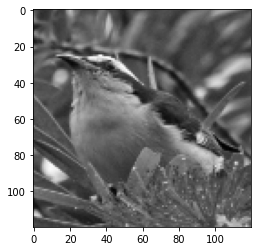

In [24]:
plt.imshow(model_train_data[1], cmap='gray')

Get train data

In [25]:
def load_data(data, labels):
	x_train, y_train = torch.from_numpy(data/255) , torch.from_numpy(labels)
	return x_train, y_train

model_train_data, model_train_labels = load_data(model_train_data, model_train_labels)

In [26]:
print(f"Train data shape {model_train_data.shape}\nTest  data shape {model_test_data.shape}")

Train data shape torch.Size([1265, 120, 120])
Test  data shape (224, 120, 120)


Train

In [27]:
best_autoencoder = None
best_score = 999

def add_noise(img):
	noise = torch.randn(img.size()) * 0.2
	noisy_img = img + noise.to(device)
	return noisy_img

def save_checkpoint(state, filename, is_best):
    """Save checkpoint if a new best is achieved"""
    if is_best:
        print("=> Saving new checkpoint")
        torch.save(state, filename)
    else:
        print("=> Validation Accuracy did not improve")
        
def pretrain(x_train, y_train, x_test, y_test, metric = None,  **kwargs):

    model = kwargs['model']
    num_epochs = kwargs['num_epochs']	
    start_epoch = 0 #checkpoint['epoch']
    
    optimizer = torch.optim.Adam(model.parameters(), lr=0.005)
    
    # ======= train loader
    train_data = []
    for i in range(len(x_train)):
        train_data.append([x_train[i], y_train[i]])
    train_loader = DataLoader(dataset=train_data)
    # =====


    for epoch in range(start_epoch, num_epochs):
        full = 0

        for data, lables in train_loader:
            
            dd = data.float().reshape([1, ENCODER_TRAIN_SHAPE[0], ENCODER_TRAIN_SHAPE[1]]).unsqueeze(0)
            output = model(dd)    
            loss = nn.MSELoss()(output, dd) 
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            full += loss.item()
    
        full = full / len(train_loader)
        print("Epoch ",epoch,", error - ",full)
        
    return model
        

In [28]:
import os
PATH = "model.pth"
if PATH not in os.listdir():
  model = AutoEncoder().to(device)
  model = pretrain(model_train_data, model_train_labels, [], [], model=model, num_epochs=10)
else:
  model = AutoEncoder()
  model.load_state_dict(torch.load(PATH))
  model.eval()

In [29]:
torch.save(model.state_dict(), PATH)

Get test data and show embedded image

In [36]:
model_test_data, model_test_labels = load_data(model_test_data, model_test_labels)

In [38]:
def get_embedded_image(image):
    dd = image.float().reshape([1, ENCODER_TRAIN_SHAPE[0], ENCODER_TRAIN_SHAPE[1]]).unsqueeze(0)
    output = model(dd)[0].reshape([ENCODER_TRAIN_SHAPE[0], ENCODER_TRAIN_SHAPE[1], 1]).detach().numpy()
    return output[:,:,0]

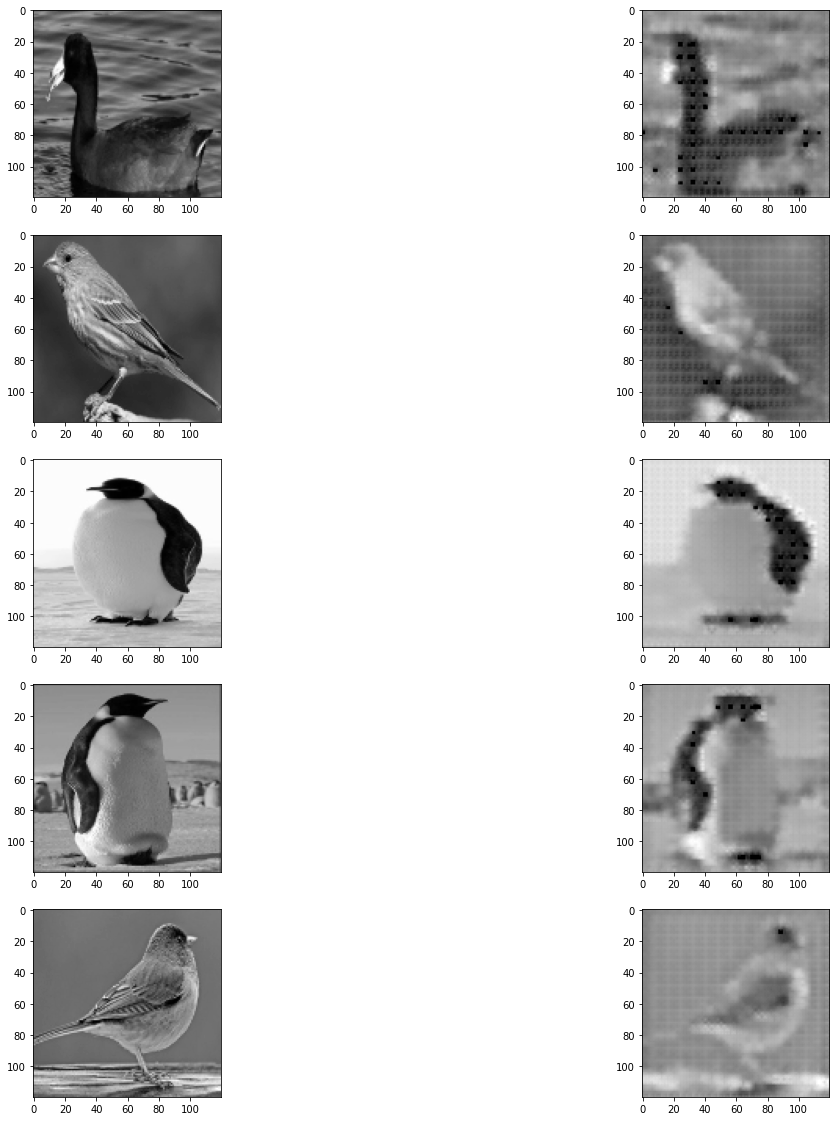

In [41]:
def plot_test_and_embedded(model_test_data):
  plt.figure(figsize=(20, 20))
  j = 0
  for i in range(5):
      plt.subplot(5, 2, j + 1)
      plt.imshow(model_test_data[i], cmap='gray')
      plt.subplot(5, 2, j + 2)
      plt.imshow(get_embedded_image(model_test_data[i]), cmap='gray')
      j += 2
  plt.show()

plot_test_and_embedded(model_test_data)

In [44]:
def get_embeded_data(model_test_data):
  embeded = []
  for i in range(len(model_test_data)):
    embeded.append(get_embedded_image(model_test_data[i]))
  return embeded

embeded_data = get_embeded_data(model_test_data)
embeded_data

[array([[0.44766027, 0.46224374, 0.48075265, ..., 0.4528534 , 0.44839138,
         0.4652443 ],
        [0.4622778 , 0.4852522 , 0.48118433, ..., 0.44444376, 0.43418583,
         0.4323745 ],
        [0.48485544, 0.4813018 , 0.46950516, ..., 0.422265  , 0.41810098,
         0.47492453],
        ...,
        [0.47839904, 0.49699903, 0.50053716, ..., 0.45941776, 0.44996148,
         0.43327707],
        [0.4980089 , 0.48919803, 0.48845968, ..., 0.44491744, 0.45080203,
         0.48342612],
        [0.5276052 , 0.51619714, 0.5305984 , ..., 0.47931904, 0.49703446,
         0.5018417 ]], dtype=float32),
 array([[0.36042464, 0.3562922 , 0.35744685, ..., 0.40897065, 0.38667244,
         0.42239642],
        [0.3483649 , 0.35160255, 0.3448931 , ..., 0.40034488, 0.37883025,
         0.39147773],
        [0.34309012, 0.34166053, 0.3414924 , ..., 0.37208503, 0.37343794,
         0.44791237],
        ...,
        [0.31755063, 0.28288695, 0.28489375, ..., 0.42803442, 0.42418286,
         0.41435567